In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def create_weekly_agg(df, value_cols, date_col='settlement_date'):
    week_info = df[date_col].dt.isocalendar()
    df = df.copy()
    df['year'] = week_info['year']
    df['week'] = week_info['week'].astype('int32')
    weekly = df.groupby(['year', 'week'])[value_cols].sum().reset_index()
    weekly['year_week'] = weekly['year'].astype(str) + '-W' + weekly['week'].astype(str).str.zfill(2)
    return weekly

def mse_cosine_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad_mse = y_pred - y_true  
    
    norm_true = np.linalg.norm(y_true) + 1e-8
    norm_pred = np.linalg.norm(y_pred) + 1e-8
    dot = np.dot(y_true, y_pred)
    lambda_cos = 1000.0  
    
   
    grad_cos = lambda_cos * (
        y_true / (norm_true * norm_pred) - 
        (dot * y_pred) / (norm_true * norm_pred**3)
    )
    
    grad_total = grad_mse + grad_cos
    hess = np.ones_like(y_true)
    return grad_total, hess


functions for data preanalysis and custom loss function

In [3]:
data = pd.read_csv('historic_demand_2009_2024_noNaN.csv')
data['settlement_date'] = pd.to_datetime(data['settlement_date'])
print(data.describe(),data.info(),data['england_wales_demand'].describe())
data['year'] = data['settlement_date'].dt.year
data['month'] = data['settlement_date'].dt.month.astype('int32')
data['week'] = data['settlement_date'].dt.isocalendar().week.astype('int32')

max_date = data['settlement_date'].max()
start_date = max_date - pd.DateOffset(months=6)
filtered = data[(data['settlement_date'] > start_date) & (data['settlement_date'] <= max_date)]

weekly = create_weekly_agg(
    filtered,
    ['embedded_wind_generation', 'embedded_solar_generation', 'england_wales_demand', 'nd', 'tsd']
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278512 entries, 0 to 278511
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   settlement_date            278512 non-null  datetime64[ns]
 1   settlement_period          278512 non-null  int64         
 2   period_hour                278512 non-null  object        
 3   nd                         278512 non-null  int64         
 4   tsd                        278512 non-null  int64         
 5   england_wales_demand       278512 non-null  int64         
 6   embedded_wind_generation   278512 non-null  int64         
 7   embedded_wind_capacity     278512 non-null  int64         
 8   embedded_solar_generation  278512 non-null  int64         
 9   embedded_solar_capacity    278512 non-null  int64         
 10  non_bm_stor                278512 non-null  int64         
 11  pump_storage_pumping       278512 non-null  int64   

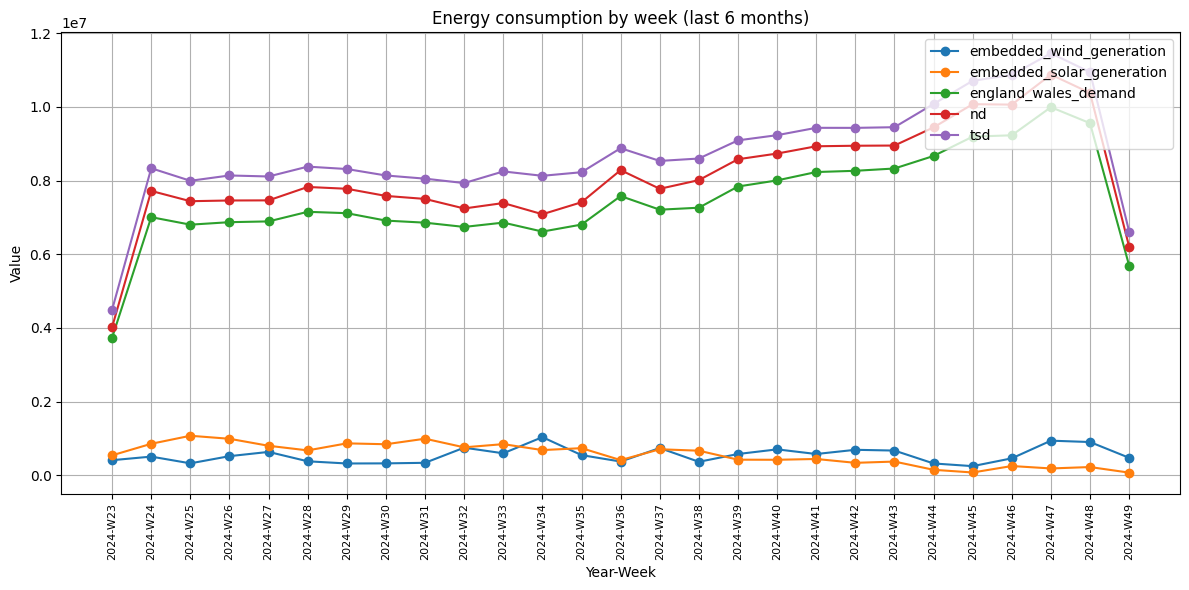

In [4]:
plt.figure(figsize=(12, 6))
for col in weekly.columns[2:-1]:
    plt.plot(weekly['year_week'], weekly[col], label=col, marker='o')
plt.title('Energy consumption by week (last 6 months)')
plt.xlabel('Year-Week')
plt.ylabel('Value')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

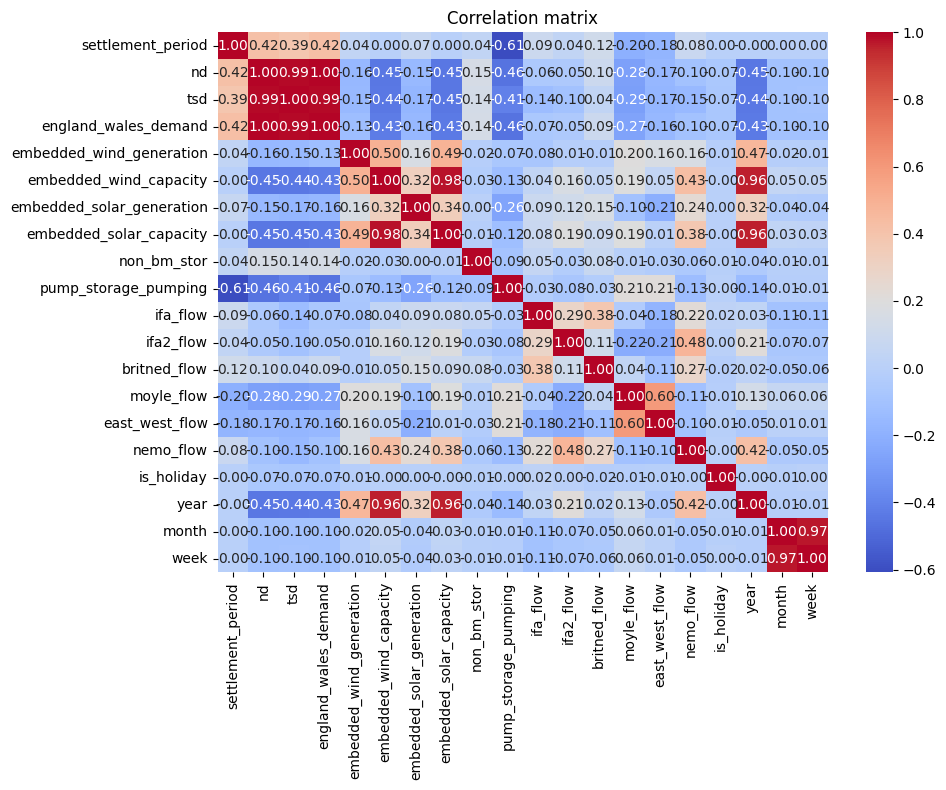

In [5]:
numeric_data = data.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

In [6]:
features = [
    'embedded_wind_generation',
    'embedded_solar_generation',
    'embedded_wind_capacity',
    'embedded_solar_capacity',
    'non_bm_stor',
    'tsd',
    'year',
    'month',
    'week'
]

X = data[features]
y = data['england_wales_demand']

split_date = data['settlement_date'].quantile(0.8)
train = data[data['settlement_date'] <= split_date]
test = data[data['settlement_date'] > split_date]
X_train, y_train = train[features], train['england_wales_demand']
X_test, y_test = test[features], test['england_wales_demand']

param_grid = {
    'n_estimators': [200,],
    'max_depth': [5],
    'learning_rate': [0.05],
    'subsample': [1.0],
    'colsample_bytree': [0.8]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R^2:{r2_score(y_test, y_pred):.2f}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
MSE: 2541337.77
MAE: 1118.43
R^2:0.92


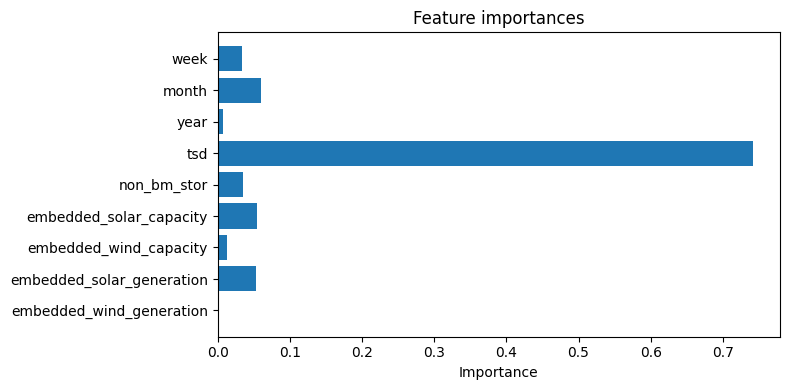

In [7]:
plt.figure(figsize=(8, 4))
plt.barh(features, best_model.feature_importances_)
plt.title('Feature importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

feature importance

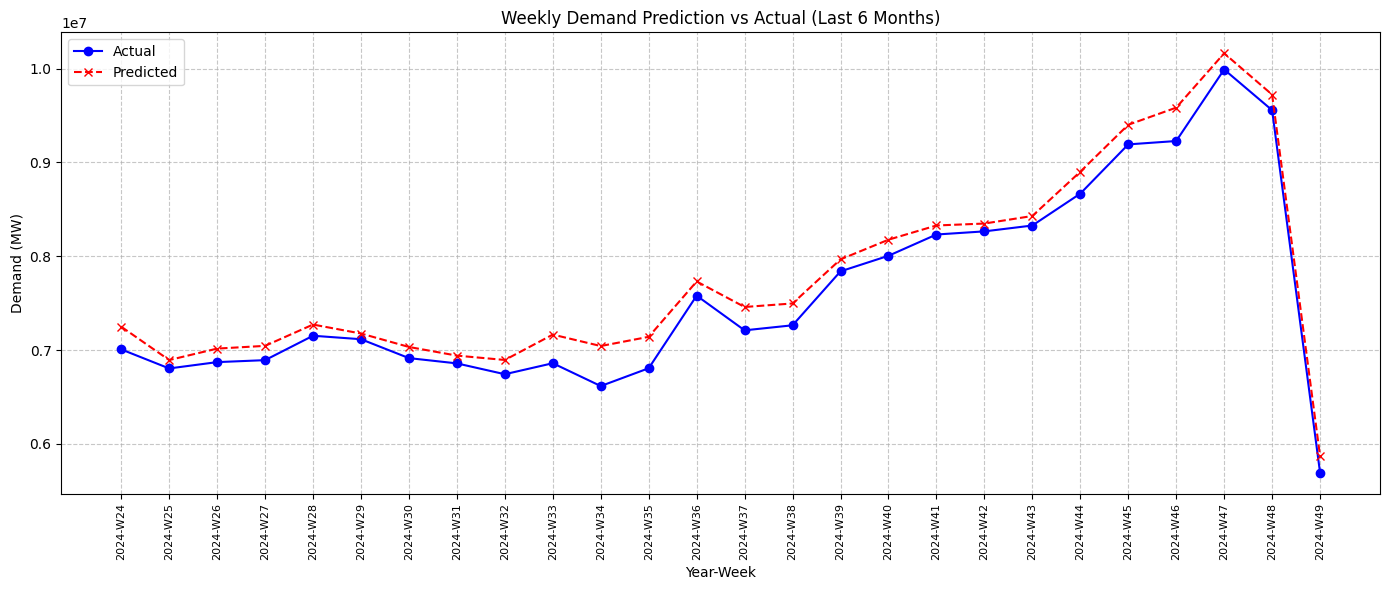

In [8]:
test_with_preds = test.copy()
test_with_preds['y_pred'] = y_pred
weekly_comparison = create_weekly_agg(
    test_with_preds, 
    ['england_wales_demand', 'y_pred']
).tail(26)

plt.figure(figsize=(14, 6))
plt.plot(weekly_comparison['year_week'], weekly_comparison['england_wales_demand'], 
         label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(weekly_comparison['year_week'], weekly_comparison['y_pred'], 
         label='Predicted', marker='x', linestyle='--', color='red')
plt.title('Weekly Demand Prediction vs Actual (Last 6 Months)')
plt.xlabel('Year-Week')
plt.ylabel('Demand (MW)')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

[0]	train-rmse:27212.81556	test-rmse:22450.53764
[10]	train-rmse:9516.77702	test-rmse:7486.59875
[20]	train-rmse:3382.63977	test-rmse:2461.63900
[30]	train-rmse:1328.34873	test-rmse:1342.39525
[40]	train-rmse:742.31890	test-rmse:1402.00390
[50]	train-rmse:618.93628	test-rmse:1500.93530
[60]	train-rmse:590.16707	test-rmse:1551.65841
[70]	train-rmse:576.74237	test-rmse:1579.01589
[80]	train-rmse:568.14125	test-rmse:1586.79904
[90]	train-rmse:561.92115	test-rmse:1600.73293
[100]	train-rmse:556.55048	test-rmse:1605.71946
[110]	train-rmse:552.45765	test-rmse:1610.14205
[120]	train-rmse:548.92445	test-rmse:1613.14544
[130]	train-rmse:545.35159	test-rmse:1615.59196
[140]	train-rmse:542.53323	test-rmse:1621.68587
[150]	train-rmse:539.82869	test-rmse:1626.67787
[160]	train-rmse:537.57143	test-rmse:1627.82206
[170]	train-rmse:534.91720	test-rmse:1634.55106
[180]	train-rmse:532.58253	test-rmse:1638.59869
[190]	train-rmse:529.92461	test-rmse:1639.71870
[199]	train-rmse:527.86844	test-rmse:1643.899

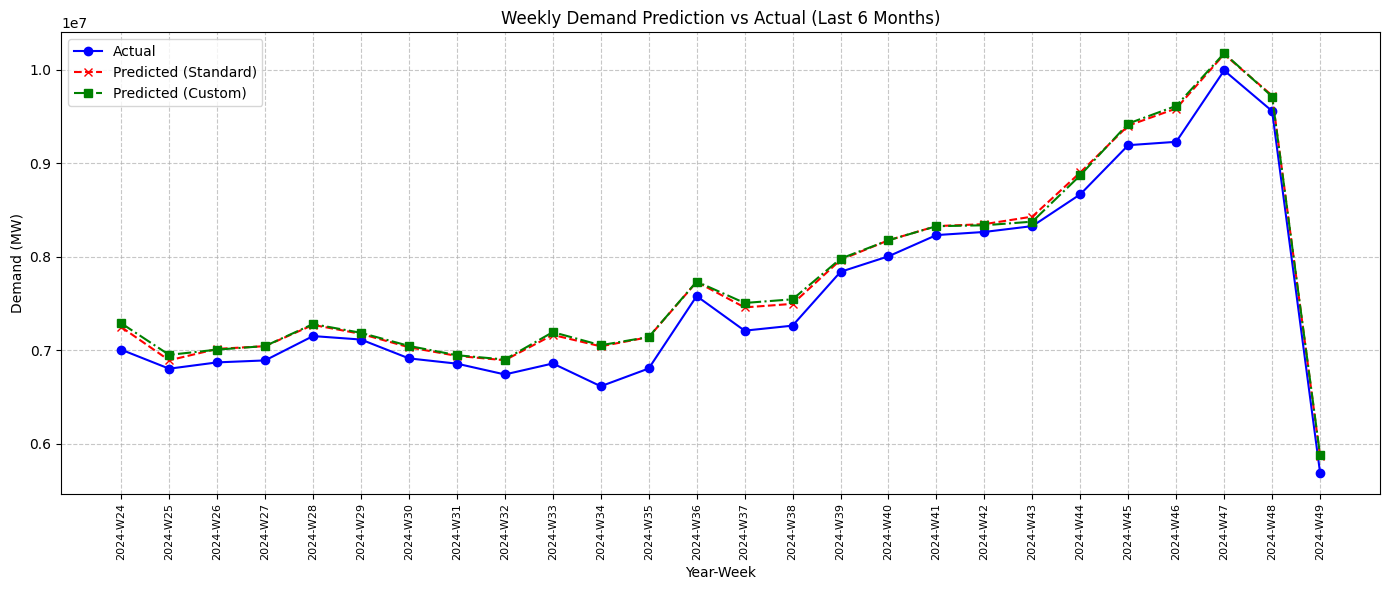

cosine_similarit after MSE loss func [[0.99864895]]
cosine_similarit after MSE+cos loss func : [[0.99859133]]


In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'eta': 0.1,
    'tree_method': 'hist',  
    'eval_metric': 'rmse'
}

evals = [(dtrain, 'train'), (dtest, 'test')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    obj=mse_cosine_obj,
    evals=evals,
    verbose_eval=10
)
y_Pred = bst.predict(dtest)

print("MSE:", mean_squared_error(y_test, y_Pred))
print("MAE:", mean_absolute_error(y_test, y_Pred))
print("R^2:", r2_score(y_test, y_Pred))

test_with_preds1 = test.copy()
test_with_preds1['y_pred'] = y_pred
test_with_preds1['y_Pred'] = y_Pred

weekly_comparison = create_weekly_agg(
    test_with_preds1, 
    ['england_wales_demand', 'y_pred', 'y_Pred']
).tail(26)

plt.figure(figsize=(14, 6))
plt.plot(weekly_comparison['year_week'], weekly_comparison['england_wales_demand'], 
         label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(weekly_comparison['year_week'], weekly_comparison['y_pred'], 
         label='Predicted (Standard)', marker='x', linestyle='--', color='red')
plt.plot(weekly_comparison['year_week'], weekly_comparison['y_Pred'], 
         label='Predicted (Custom)', marker='s', linestyle='-.', color='green')
plt.title('Weekly Demand Prediction vs Actual (Last 6 Months)')
plt.xlabel('Year-Week')
plt.ylabel('Demand (MW)')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics.pairwise import cosine_similarity
print("cosine_similarit after MSE loss func", cosine_similarity([y_test], [y_pred]))
print("cosine_similarit after MSE+cos loss func :", cosine_similarity([y_test], [y_Pred]))


custom loss function show better trend although as R^2 can be depended from cosine simularity